In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.io import loadmat
save = True

**Table of contents**<a id='toc0_'></a>    
- [Fitting of experimental profiles and parameter estimation](#toc1_)    
  - [pMad-*brk* response curve (model)](#toc1_1_)    
  - [pMad-*dad* response curve (model)](#toc1_2_)    
  - [pMad-*tkv* response curve (model)](#toc1_3_)    
  - [Fitting DadRNAi Parameters](#toc1_4_)    
- [Full dynamics using fitted parameters - chemostat](#toc2_)    
- [Gradients in space](#toc3_)    
- [Genotypes](#toc4_)    
  - [(a) ubi-tkv: set stkv2t=0 after parameter fit](#toc4_1_)    
  - [(b) dad mutant: set sdad1t=sdad2t=0 after fit](#toc4_2_)    
  - [(c) brk replaced by strong tkv](#toc4_3_)    
  - [(d) brk replaced by dadRNAi (strong repression)](#toc4_4_)    
  - [(e) dadRNAi parameter sweep and fitting](#toc4_5_)    
  - [(f) Tkv Overexpression Fitting](#toc4_6_)    
  - [(g) Dad mutant exploration - species M](#toc4_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Fitting of experimental profiles and parameter estimation](#toc0_)

In [6]:
# extract fitting data
df_wtbrk = pd.read_excel(r"./brk_feedback_data/pMad-brktrn_WT-brkmut.xlsx", header=1)
colnames_wtbrk = df_wtbrk.columns

df_4EGFP = pd.read_excel(r"./brk_feedback_data/dad4EGFP-pMad_WT-brkmut.xlsx", header=2)
colnames_4EGFP = df_4EGFP.columns[:4]

df_lacZ = pd.read_excel(r"./brk_feedback_data/dadlacZ-pMad_WT-brkmut.xlsx", header=1)
colnames_lacZ = df_lacZ.columns

df_tkv = pd.read_excel(r"./brk_feedback_data/pMad-TkvGFP_WT-brkmut.xlsx", header=1)
colnames_tkv = df_tkv.columns

# TODO need dadrnai data here
# df_dadrnai = pd.read_excel(r"./brk_feedback_data/pMad-DadRNAi.xlsx", header=0)[:42]
df_dadrnai = pd.read_excel(r"./brk_feedback_data/pMad-DadRNAi_Ventral.xlsx", header=0)[:42]
colnames_dadrnai = df_dadrnai.columns

# extract spatial gradient data
df_spatgrad = pd.read_excel(
    r"./brk_feedback_data/pMad_and_brktrn_profiles.xlsx", header=2
)
colnames_spatgrad = df_spatgrad.columns

pmad_wt_interp = lambda x: np.interp(x, df_spatgrad["x/L"], df_spatgrad["Mean"])
pmad_mut_interp = lambda x: np.interp(x, df_spatgrad["x/L"], df_spatgrad["Mean.2"])
brk_wt_interp = lambda x: np.interp(x, df_spatgrad["x/L"], df_spatgrad["Mean.1"])
brk_mut_interp = lambda x: np.interp(x, df_spatgrad["x/L"], df_spatgrad["Mean.3"])

In [7]:
# unknown parameters
k5 = 1
k6 = 0.001 * k5  # we know it is smaller but how small
global k5global, k6global
k5global = k5
k6global = k6

# graphically determined parameters
sbrkt = 1
global sbrktglobal
sbrktglobal = sbrkt

spmadt = 1  # this can be fixed because things simply happens at a different value of [dpp], which is external
global spmadtglobal
spmadtglobal = spmadt

stkv1t = 1  # can be fixed because increasing both stkv1,2 while decreasing spmad accordingly leaves unchanged
stkv2t = 2 * stkv1t
global stkv1tglobal, stkv2tglobal
stkv1tglobal = stkv1t
stkv2tglobal = stkv2t

madtot = sbrkt
global madtotglobal
madtotglobal = madtot

sdad1t = 0.1 * sbrkt
sdad2t = sdad1t
global sdad1tglobal, sdad2tglobal
sdad1tglobal = sdad1t
sdad2tglobal = sdad2t

## <a id='toc1_1_'></a>[pMad-*brk* response curve (model)](#toc0_)

\begin{equation*} [brk] = \tilde{s}_{\rm brk} \frac{1}{1 + ([pMad]/k_7)^{h_1}} \end{equation*}

In [8]:
def brk_mut(pMad, k7, h):
    return 1 / (1 + (pMad / k7) ** h)

In [9]:
fitpar, cov = curve_fit(
    brk_mut,
    df_wtbrk[colnames_wtbrk[2]].to_numpy()[:-20],
    df_wtbrk[colnames_wtbrk[3]].to_numpy()[:-20],
)

print("k7=" + str(fitpar[0]) + " +- " + str(np.sqrt(np.diag(cov))[0]))
print("h1=" + str(fitpar[1]) + " +- " + str(np.sqrt(np.diag(cov))[1]))

k7global = fitpar[0]
h1global = fitpar[1]

k7=0.045919094823616516 +- 0.0008495428702463329
h1=1.5998605980103444 +- 0.045526175474679166


/var/folders/f4/ff3z4kt9185_9m1nt9spmzr00000gn/T/ipykernel_64301/2942199735.py:2: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (pMad / k7) ** h)


## <a id='toc1_2_'></a>[pMad-*dad* response curve (model)](#toc0_)

\begin{equation*} 
[dad] = \frac{1}{1 + ([brk]/k_3)^{h_2}} \left[ \tilde{s}_{\rm dad}^{(I)} + \tilde{s}_{\rm dad}^{(II)}  \frac{([pMad]/k_4)^{h_3}}{1+([pMad]/k_4)^{h_3}} \right] \end{equation*} 

In [10]:
def dad_wt(pMad, k4, h3, k3, h2):
    sdad1t = 0.5  # chosen to match peak dad concentration normalized to 1
    sdad2t = 0.5
    k7 = k7global
    h1 = h1global
    sbrkt = sbrktglobal
    brk = sbrkt / (1 + (pMad / k7) ** h1)
    return (sdad1t + sdad2t * ((pMad / k4) ** h3 / (1 + (pMad / k4) ** h3))) / (
        1 + (brk / k3) ** h2
    )


def dad_brkmut(pMad, k4, h3):
    sdad1t = 0.5
    sdad2t = 0.5
    k7 = k7global
    return sdad1t + sdad2t * ((pMad / k4) ** h3 / (1 + (pMad / k4) ** h3))

In [11]:
fitpar, cov = curve_fit(
    dad_brkmut,
    df_lacZ[colnames_lacZ[2]].to_numpy()[:-10],
    df_lacZ[colnames_lacZ[3]].to_numpy()[:-10],
)

print("k4=" + str(fitpar[0]) + " +- " + str(np.sqrt(np.diag(cov))[0]))
print("h3=" + str(fitpar[1]) + " +- " + str(np.sqrt(np.diag(cov))[1]))

fitpar_wt, cov_wt = curve_fit(
    lambda pMad, k3, h2: dad_wt(pMad, fitpar[0], fitpar[1], k3, h2),
    df_lacZ[colnames_lacZ[0]],
    df_lacZ[colnames_lacZ[1]],
)
print("k3=" + str(fitpar_wt[0]) + " +- " + str(np.sqrt(np.diag(cov_wt))[0]))
print("h2=" + str(fitpar_wt[1]) + " +- " + str(np.sqrt(np.diag(cov_wt))[1]))

global k4global, h3global, k3global, h2global
k4global = fitpar[0]
h3global = fitpar[1]
k3global = fitpar_wt[0]
h2global = fitpar_wt[1]

k4=0.5961565032478253 +- 0.01884019529041045
h3=3.145184671835497 +- 0.3412631862087172
k3=0.15031297509313563 +- 0.004941577315536502
h2=2.9808273930796703 +- 0.32290991443067435


/var/folders/f4/ff3z4kt9185_9m1nt9spmzr00000gn/T/ipykernel_64301/381206253.py:17: RuntimeWarning: invalid value encountered in power
  return sdad1t + sdad2t * ((pMad / k4) ** h3 / (1 + (pMad / k4) ** h3))


-- The above are the key parameters extracted from this fit-- 

## <a id='toc1_3_'></a>[pMad-*tkv* response curve (model)](#toc0_)

$ [tkv] = \tilde{s}_{\rm tkv}^{(I)} + \tilde{s}_{\rm tkv}^{(II)} \frac{([brk]/k_2)^{h_4}}{1 + ([brk]/k_2)^{h_4}} $ 

In [12]:
def mut_tkv(pMad, a0, a1, a2):
    return a0 + a1 * pMad + a2 * pMad**2


def tkv(pMad, k2, stkv2, h4):
    brk_p = brk_mut(pMad, k7global, h1global)
    return stkv2 * (brk_p / k2) ** h4 / (1 + (brk_p / k2) ** h4)

In [13]:
fitpar_mut, cov_mut = curve_fit(
    mut_tkv, df_tkv[colnames_tkv[2]], df_tkv[colnames_tkv[3]]
)
fitpar_emp = fitpar_mut

logxmax = np.log10(np.max(df_tkv[colnames_tkv[2]]))
logxmin = np.log10(np.min(df_tkv[colnames_tkv[2]]))

subtr = mut_tkv(
    df_tkv[colnames_tkv[0]].to_numpy(), fitpar_mut[0], fitpar_mut[1], fitpar_mut[2]
)

fitpar, cov = curve_fit(tkv, df_tkv[colnames_tkv[0]], df_tkv[colnames_tkv[1]] - subtr)
stkv2_forplot = fitpar[1]

print("k2=" + str(fitpar[0]) + " +- " + str(np.sqrt(np.diag(cov))[0]))
print("h4=" + str(fitpar[2]) + " +- " + str(np.sqrt(np.diag(cov))[2]))

global k2global, h4global
k2global = fitpar[0]
h4global = fitpar[2]

k2=0.5886647379544324 +- 0.03678677999655555
h4=5.194242375629819 +- 1.091672325554237


## <a id='toc1_4_'></a>[Fitting DadRNAi Parameters](#toc0_)

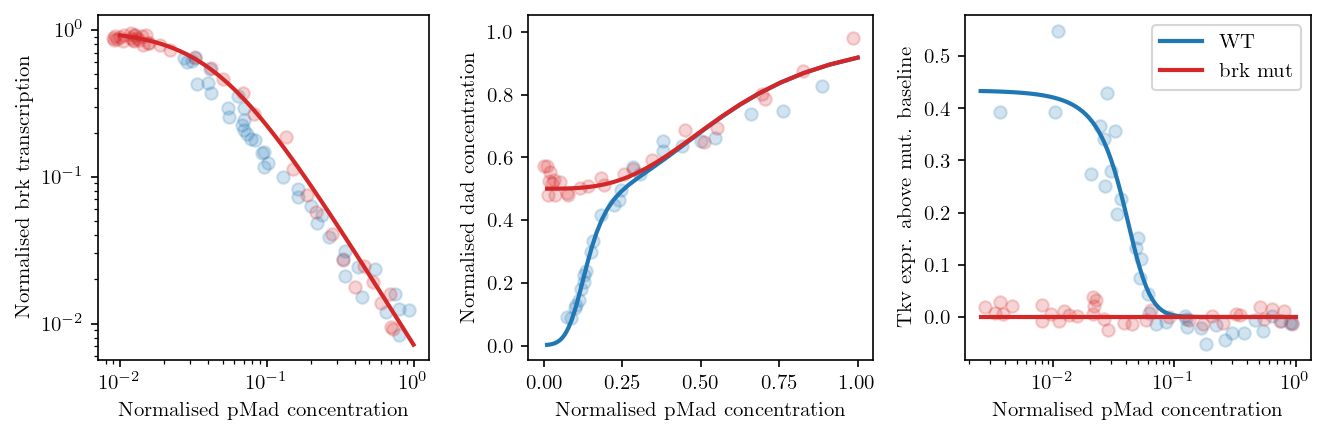

In [14]:
## FIG 7(A-C)
plt.close("all")

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ps = np.logspace(-2, 0, 50)

ax[0].scatter(
    df_wtbrk[colnames_wtbrk[0]], df_wtbrk[colnames_wtbrk[1]], alpha=0.2, c="tab:blue"
)
ax[0].scatter(
    df_wtbrk[colnames_wtbrk[2]].to_numpy(),
    df_wtbrk[colnames_wtbrk[3]].to_numpy(),
    alpha=0.2,
    c="tab:red",
)
ax[0].plot(
    ps,
    [brk_mut(p, k7global, h1global) for p in ps],
    label="brk mut",
    linewidth=2,
    c="tab:red",
)
ax[0].loglog()
ax[0].set(xlabel="Normalised pMad concentration", ylabel="Normalised brk transcription")
ax[0].axis("square")

ax[1].scatter(
    df_lacZ[colnames_lacZ[0]].to_numpy(),
    df_lacZ[colnames_lacZ[1]].to_numpy(),
    alpha=0.2,
    c="tab:blue",
)
ax[1].scatter(
    df_lacZ[colnames_lacZ[2]].to_numpy(),
    df_lacZ[colnames_lacZ[3]].to_numpy(),
    alpha=0.2,
    c="tab:red",
)
ax[1].plot(
    ps,
    [dad_wt(p, k4global, h3global, k3global, h2global) for p in ps],
    label="WT",
    linewidth=2,
    c="tab:blue",
)
ax[1].plot(
    ps,
    [dad_brkmut(p, k4global, h3global) for p in ps],
    label="brk mut",
    linewidth=2,
    c="tab:red",
)
ax[1].set(xlabel="Normalised pMad concentration", ylabel="Normalised dad concentration")
ax[1].axis("square")

ps = np.logspace(-2.6, 0, 100)
subtr = mut_tkv(
    df_tkv[colnames_tkv[0]].to_numpy(), fitpar_emp[0], fitpar_emp[1], fitpar_emp[2]
)
ax[2].scatter(
    df_tkv[colnames_tkv[0]], df_tkv[colnames_tkv[1]] - subtr, alpha=0.2, c="tab:blue"
)
ax[2].scatter(
    df_tkv[colnames_tkv[2]], df_tkv[colnames_tkv[3]] - subtr, alpha=0.2, c="tab:red"
)
ax[2].set(
    xlabel="Normalised pMad concentration", ylabel="Tkv expr. above mut. baseline"
)
ax[2].semilogx()
ax[2].plot(
    ps,
    [tkv(p, k2global, stkv2_forplot, h4global) for p in ps],
    linewidth=2,
    label="WT",
    c="tab:blue",
)
ax[2].plot(ps, [0 for p in ps], linewidth=2, label="brk mut", c="tab:red")
ax[2].legend()

plt.tight_layout()

# <a id='toc2_'></a>[Full dynamics using fitted parameters - chemostat](#toc0_)

\begin{align*}
\frac{d}{dt} [dpp]_f &= D\Delta [dpp]_f + \frac{1}{h}\left[- \frac{k_{\rm on} [tkv]_f}{k_1} [dpp]_f + k_{\rm off} [tkv]_b \right] + j(x) \\
\frac{d}{dt} [pMad] &= p_{\rm pMad} [tkv]_b \frac{[mad]/k_5}{1 + [mad]/k_5 + [dad]/k_6} - r_{\rm pMad} [pMad]  \\ 
\frac{d}{dt} [brk] &= s_{\rm brk} \frac{1}{1 + ([pMad]/k_7)^{h_1}} - r_{\rm brk}[brk] \\
\frac{d}{dt} [dad] &= \frac{1}{1 + ([brk]/k_3)^{h_2}} \left[ s_{\rm dad}^{(I)} + s_{\rm dad}^{(II)} \frac{([pMad]/k_4)^{h_3}}{1+([pMad]/k_4)^{h_3}} \right] - r_{\rm dad}[dad] \\
\frac{d}{dt} [tkv]_f &= s_{\rm tkv}^{(I)} + s_{\rm tkv}^{(II)} \frac{([brk]/k_2)^{h_4}}{1 + ([brk]/k_2)^{h_4}} - \frac{k_{\rm on} [tkv]_f}{k_1} [dpp]_f + k_{\rm off} [tkv]_b  - r_{\rm tkv} [tkv]_f \\
\frac{d}{dt} [tkv]_b &= \frac{k_{\rm on} [tkv]_f}{k_1} [dpp]_f - k_{\rm off} [tkv]_b - r_{\rm int} [tkv]_b  
\end{align*}

At steady state:
    

\begin{align*}
0 &= D \Delta [dpp] - \frac{r_{\rm dpp} [tkv]}{h k_1}[dpp]\\
[pMad]  &= \tilde{s}_{\rm pMad} [dpp]_f [tkv]_f \frac{[mad_{\rm tot}]/k_5}{1 + [mad_{\rm tot}]/k_5 + [dad]/k_6}  \\
[brk] &= \tilde{s}_{\rm brk} \frac{1}{1 + ([pMad]/k_7)^{h_1}} \\
[dad] &= \frac{1}{1 + ([brk]/k_3)^{h_2}} \left[ \tilde{s}_{\rm dad}^{(I)} + \tilde{s}_{\rm dad}^{(II)}  \frac{([pMad]/k_4)^{h_3}}{1+([pMad]/k_4)^{h_3}} \right]\\
[tkv]_f   &= \tilde{s}_{\rm tkv}^{(I)} + \tilde{s}_{\rm tkv}^{(II)} \frac{([brk]/k_2)^{h_4}}{1 + ([brk]/k_2)^{h_4}} \\

\end{align*}

In [15]:
def equations_GRN_leastsq(vars, dpp, k5, k6):
    pmad, brk, dad, tkv = vars
    eq1 = (
        spmadtglobal
        * dpp
        * tkv
        * (madtotglobal / k5)
        / (1 + (madtotglobal / k5) + (dad / k6))
        / pmad
        - 1
    )
    eq2 = sbrktglobal / (1 + (pmad / k7global) ** h1global) / brk - 1
    eq3 = (
        sdad1tglobal
        + sdad2tglobal
        * (pmad / k4global) ** h3global
        / (1 + (pmad / k4global) ** h3global)
    ) / (1 + (brk / k3global) ** h2global) / dad - 1
    eq4 = (
        stkv1tglobal
        + stkv2tglobal
        * (brk / k2global) ** h4global
        / (1 + (brk / k2global) ** h4global)
    ) / tkv - 1
    return np.array([eq1, eq2, eq3, eq4])


def equations_GRN_brkmut_leastsq(vars, dpp, k5, k6):
    pmad, dad, tkv = vars
    eq1 = (
        spmadtglobal
        * dpp
        * tkv
        * (madtotglobal / k5)
        / (1 + (madtotglobal / k5) + (dad / k6))
        / pmad
        - 1
    )
    eq3 = (
        sdad1tglobal
        + sdad2tglobal
        * (pmad / k4global) ** h3global
        / (1 + (pmad / k4global) ** h3global)
    ) / dad - 1
    eq4 = stkv1tglobal / tkv - 1
    return [eq1, eq3, eq4]

In [16]:
dpps = np.logspace(-3, 2, 100)
pmads, brks, dads, tkvs = [np.zeros(dpps.shape[0]) for _ in range(4)]
pmad_muts, brk_muts, dad_muts, tkv_muts = [np.zeros(dpps.shape[0]) for _ in range(4)]
for i, dpp in enumerate(dpps):
    sol = least_squares(
        lambda vars: equations_GRN_leastsq(vars, dpp, k5, k6),
        (1, 1, 1, 1),
        bounds=(0, np.inf),
    )
    pmads[i], _, dads[i], tkvs[i] = sol.x
    sol_mut = least_squares(
        lambda vars: equations_GRN_brkmut_leastsq(vars, dpp, k5, k6),
        (1, 1, 1),
        bounds=(0, np.inf),
    )
    pmad_muts[i], dad_muts[i], tkv_muts[i] = sol_mut.x
brk_transcriptions = 1 / (1 + (pmads / k7global) ** h1global)
brk_transcription_muts = 1 / (1 + (pmad_muts / k7global) ** h1global)
names = ["brk transcription", "[pmad]", "[dad]", "[tkv]"]
wt_data = {
    "[dpp]": dpps,
    "[pmad]": pmads,
    "brk transcription": brk_transcriptions,
    "[dad]": dads,
    "[tkv]": tkvs,
}
mut_data = {
    "[dpp]": dpps,
    "[pmad]": pmad_muts,
    "brk transcription": brk_transcription_muts,
    "[dad]": dad_muts,
    "[tkv]": tkv_muts,
}

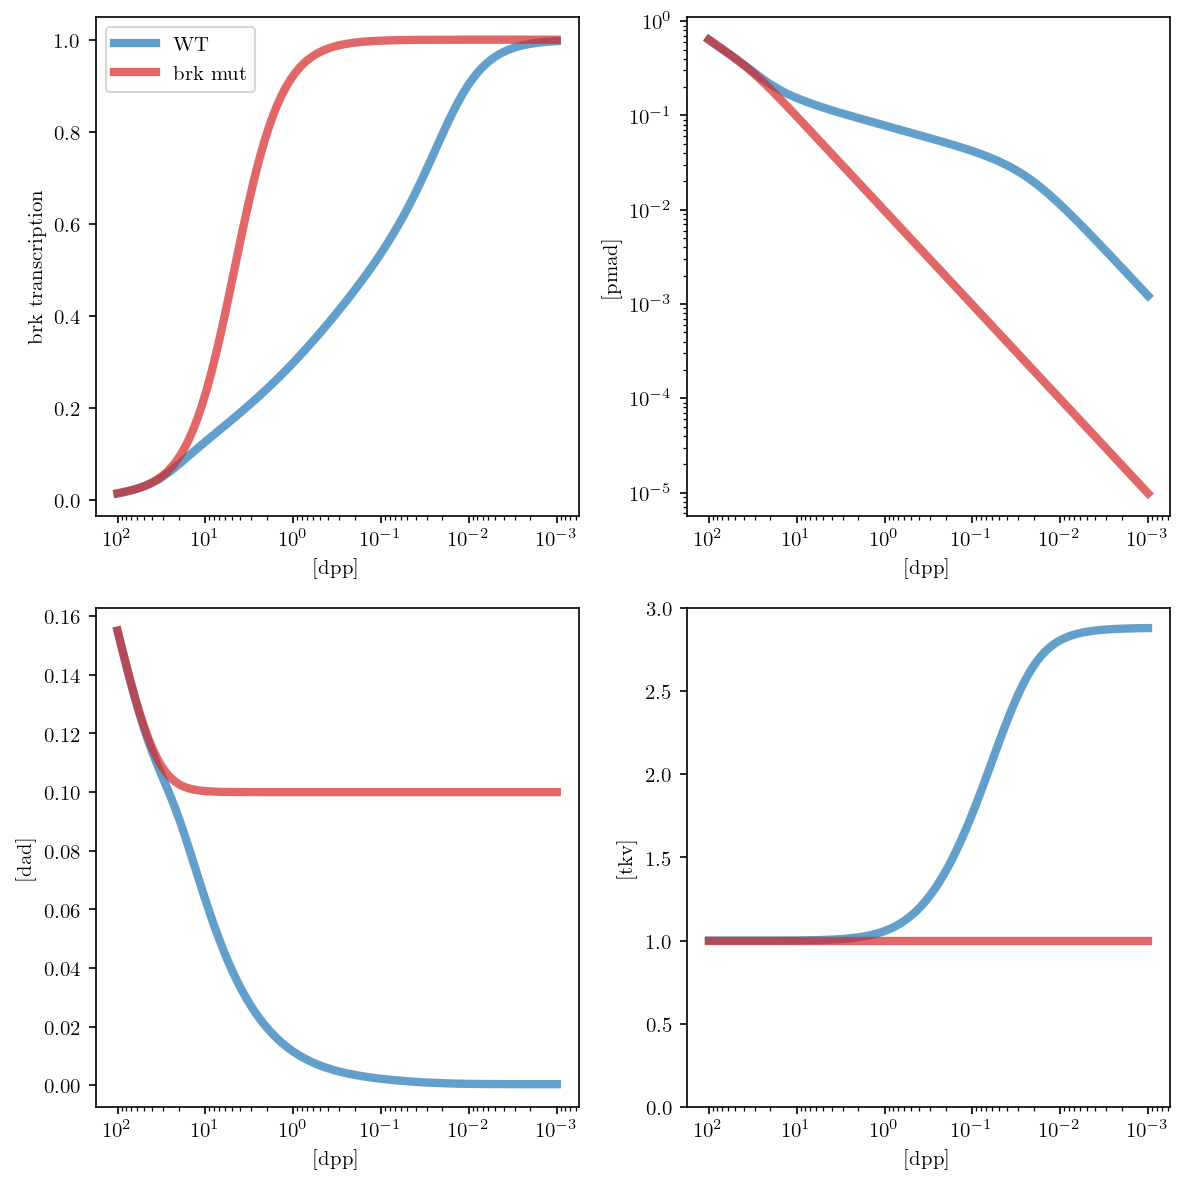

In [17]:
plt.close("all")
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, name in enumerate(names):
    ax[i].plot(dpps, wt_data[name], c="tab:blue", linewidth=4, alpha=0.7)
    ax[i].plot(dpps, mut_data[name], c="tab:red", linewidth=4, alpha=0.7)
    ax[i].semilogx()
    ax[i].set(xlabel="[dpp]", ylabel=name)
    ax[i].invert_xaxis()
ax[1].loglog()
ax[0].legend(["WT", "brk mut"])
ax[3].set(ylim=(0, 3))
plt.tight_layout()
plt.tight_layout()

In [18]:
# save data to txt files
output = np.zeros((len(dpps), 9))
output[:, 0] = dpps
output[:, 1] = brk_transcriptions
output[:, 2] = brk_transcription_muts
output[:, 3] = pmads
output[:, 4] = pmad_muts
output[:, 5] = dads
output[:, 6] = dad_muts
output[:, 7] = tkvs
output[:, 8] = tkv_muts

np.savetxt("./brk_feedback_data/dpp_response_curves.txt", output) if save else None

# <a id='toc3_'></a>[Gradients in space](#toc0_)

In [19]:
def c_dep_sol_WT(c, k5, k6):
    sol = least_squares(
        lambda vars: equations_GRN_leastsq(vars, c, k5, k6),
        (1, 1, 1, 1),
        bounds=(0, np.inf),
    )
    pmad, brk, dad, tkv = sol.x
    return pmad, brk, dad, tkv

def c_dep_sol_mut(c, k5, k6):
    sol = least_squares(
        lambda vars: equations_GRN_brkmut_leastsq(vars, c, k5, k6),
        (1, 1, 1),
        bounds=(0, np.inf),
    )
    pmad, dad, tkv = sol.x
    return pmad, 0, dad, tkv


In [20]:
def GRN_spatial_integrator(c_dep_sol, lbc_type="dirichlet", lbc_val=None, verbose=False):
    """Solve the diffusion equation for the GRN model. Acceptable BCs are dirichlet and neumann. 
    c_dep_sol should return a tuple of values in the order pmad, brk, dad, tkv, others."""
    interpsteps = 250
    dpps = np.logspace(-6, 3, interpsteps)
    print("#Defining interpolating functions ...") if verbose else None
    array_for_interp = np.array([c_dep_sol(dpp) for dpp in dpps])
    n_species = array_for_interp.shape[1] 
    interp_functions = [lambda c, ind=i: np.interp(c, dpps, array_for_interp[:,ind]) for i in range(n_species)]
    pmad_int, tkv_int = interp_functions[0], interp_functions[3]
    print("#Completed definition of interpolating functions ...") if verbose else None
    L = 100.0  # Length of the domain
    T = 2000.0  # Total simulation time
    Nx = 100  # Number of spatial grid points
    Nt = 20000  # Number of time steps
    D = 1.0  # Diffusion coefficient
    k = 0.01  # Degradation rate constant
    dx = L / Nx  # Spatial step size
    dt = T / Nt  # Time step size
    x = np.linspace(0, L, Nx)
    if lbc_val is None:
        lbc_val = least_squares(
            lambda d: (pmad_int(d) - 1) ** 2, (2), bounds=(1e-4, 1e3)
        ).x[0]
        print("#", lbc_val, pmad_int(lbc_val)) if verbose else None
    lam = np.sqrt(D/k)
    if lbc_type == "dirichlet":
        C = lbc_val*np.exp(-x/lam)
        C[0] = lbc_val
    elif lbc_type == "neumann":
        C = -1/lam * lbc_val*np.exp(-x/lam)
        C[0] = C[1] - lbc_val * dx
    else:
        raise ValueError("Invalid boundary condition")
    C_old = np.copy(C)
    for n in range(Nt):
        diffusion = C[1:-1] + D * (C[:-2] - 2 * C[1:-1] + C[2:]) / dx**2 * dt
        C[1:-1] = diffusion - k * tkv_int(C[1:-1]) * C[1:-1] * dt
        C[-1] = C[-2]  # no-flux boundary condition at x=L (right boundary)
        if lbc_type == "dirichlet":
            C[0] = lbc_val
        elif lbc_type == "neumann":
            C[0] = C[1] - lbc_val * dx
        if n % 100 == 0 and n>100:
            # check convergence
            relative_change = np.linalg.norm(C - C_old)/C_old
            if np.all(relative_change < 1e-1):
                print("Converged at iteration", n) if verbose else None
                break
            C_old = np.copy(C)    
    return x, C, *[interp_func(C) for interp_func in interp_functions]

def compare(c_dep_sol_1, c_dep_sol_2, k5=1, k6=1e-3):
    results_1 = GRN_spatial_integrator(lambda dpp: c_dep_sol_1(dpp, k5, k6))
    vx, vdpp, vpmad_1 = results_1[0:3]
    vbrk_trans_1 = 1 / (1 + (vpmad_1 / k7global) ** h1global)
    J0 = (vdpp[1] - vdpp[0]) / (vx[1] - vx[0])
    results_2 = GRN_spatial_integrator(
        lambda dpp: c_dep_sol_2(dpp, k5, k6), lbc_type="neumann", lbc_val=J0
    )
    vpmad_2 = results_2[2]
    vbrk_trans_2 = 1 / (1 + (vpmad_2 / k7global) ** h1global)
    return vx, vpmad_1, vbrk_trans_1, vpmad_2, vbrk_trans_2

In [21]:
vx, vpmad, vbrk_trans, vpmad_mut, vbrk_trans_mut = compare(c_dep_sol_WT, c_dep_sol_mut)

[Text(0.5, 0, 'x/L'), (0.0, 80.0), (0.0, 1.1)]

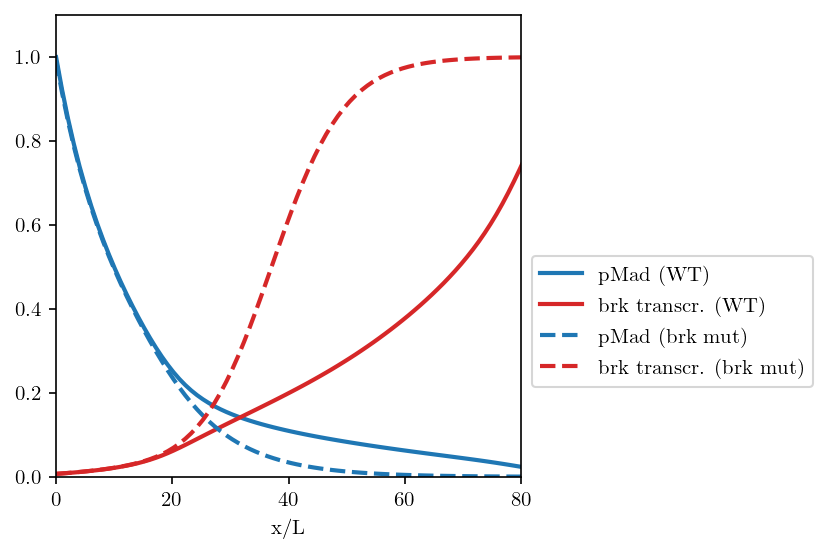

In [22]:
plt.close("all")
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(vx, vpmad, c="tab:blue", linestyle="-", label="pMad (WT)", linewidth=2)
ax.plot(vx, vbrk_trans, c="tab:red", label="brk transcr. (WT)", linewidth=2)
ax.plot(
    vx, vpmad_mut, c="tab:blue", linestyle="--", label="pMad (brk mut)", linewidth=2
)
ax.plot(
    vx,
    vbrk_trans_mut,
    c="tab:red",
    linestyle="--",
    label="brk transcr. (brk mut)",
    linewidth=2,
)
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set(xlabel="x/L", xlim=(0, 80), ylim=(0, 1.1))

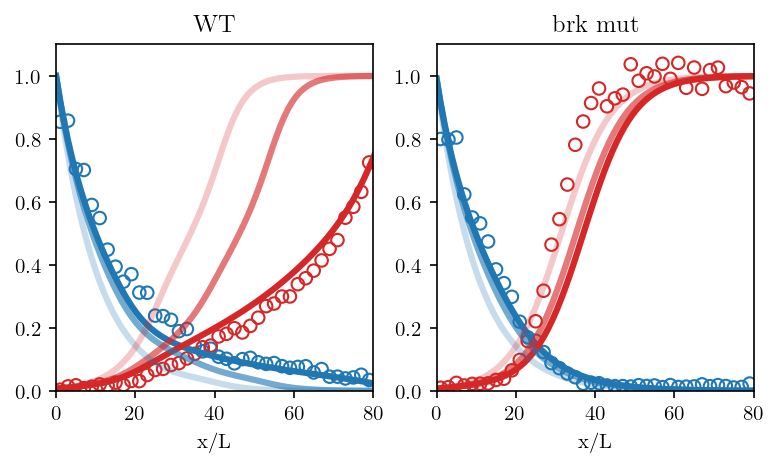

In [23]:
plt.close("all")
## Investigating Varying k5 and k6
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
for k6 in np.logspace(-3, 0, 3):
    vx, vpmad, vbrk_trans, vpmad_mut, vbrk_trans_mut = compare(c_dep_sol_WT, c_dep_sol_mut, k6=k6)
    alpha = (-np.log10(k6) + 1) / 4
    ax[0].plot(vx,vpmad,c="tab:blue",linestyle="-",label="pMad (WT)",linewidth=3,alpha=alpha)
    ax[0].plot(vx, vbrk_trans, c="tab:red", label="brk transcr. (WT)", linewidth=3, alpha=alpha)
    ax[1].plot(vx,vpmad_mut,c="tab:blue",linestyle="-",label="pMad (brk mut)",linewidth=3,alpha=alpha)
    ax[1].plot(vx,vbrk_trans_mut,c="tab:red",linestyle="-",label="brk transcr. (brk mut)",linewidth=3,alpha=alpha)

ax[0].set(xlabel="x/L", xlim=(0, 80), ylim=(0, 1.1), title="WT")
ax[0].scatter(100 * df_spatgrad["x/L"],df_spatgrad["Mean"],alpha=1,marker="o",edgecolor="tab:blue",facecolor="None")
ax[0].scatter(100 * df_spatgrad["x/L"],df_spatgrad["Mean.1"] / 0.9,alpha=1,marker="o",edgecolor="tab:red",facecolor="None")
ax[1].set(xlabel="x/L", xlim=(0, 80), ylim=(0, 1.1), title="brk mut")
ax[1].scatter(100 * df_spatgrad["x/L"],df_spatgrad["Mean.2"],alpha=1,marker="o",edgecolor="tab:blue",facecolor="None")
ax[1].scatter(100 * df_spatgrad["x/L"],df_spatgrad["Mean.3"] / 0.9,alpha=1,marker="o",edgecolor="tab:red",facecolor="None")
plt.show()

# <a id='toc4_'></a>[Genotypes](#toc0_)

In [24]:
def equations_GRN_nobrkdad_leastsq(vars, dpp, k5, k6):
    pmad, brk, dad, tkv = vars
    eq1 = (
        spmadtglobal
        * dpp
        * tkv
        * (madtotglobal / k5)
        / (1 + (madtotglobal / k5) + (dad / k6))
        / pmad
        - 1
    )
    eq2 = sbrktglobal / (1 + (pmad / k7global) ** h1global) / brk - 1
    eq3 = (
        sdad1tglobal
        + sdad2tglobal
        * (pmad / k4global) ** h3global
        / (1 + (pmad / k4global) ** h3global)
    ) / dad - 1
    eq4 = (
        stkv1tglobal
        + stkv2tglobal
        * (brk / k2global) ** h4global
        / (1 + (brk / k2global) ** h4global)
    ) / tkv - 1
    return [eq1, eq2, eq3, eq4]


def equations_GRN_nobrktkv_leastsq(vars, dpp, k5, k6, k3):
    pmad, brk, dad, tkv = vars
    eq1 = (
        spmadtglobal
        * dpp
        * tkv
        * (madtotglobal / k5)
        / (1 + (madtotglobal / k5) + (dad / k6))
        / pmad
        - 1
    )
    eq2 = sbrktglobal / (1 + (pmad / k7global) ** h1global) / brk - 1
    eq3 = (
        sdad1tglobal
        + sdad2tglobal
        * (pmad / k4global) ** h3global
        / (1 + (pmad / k4global) ** h3global)
    ) / (1 + (brk / k3global) ** h2global) / dad - 1
    eq4 = stkv1tglobal / tkv - 1
    return [eq1, eq2, eq3, eq4]


def c_dep_sol_nobrkdad(c, k5, k6):
    sol = least_squares(
        lambda vars: equations_GRN_nobrkdad_leastsq(vars, c, k5, k6),
        (1, 1, 1, 1),
        bounds=(0, np.inf),
    )
    pmad, brk, dad, tkv = sol.x
    return pmad, brk, dad, tkv


def c_dep_sol_nobrktkv(c, k5, k6, k3=k3global):
    sol = least_squares(
        lambda vars: equations_GRN_nobrktkv_leastsq(vars, c, k5, k6, k3),
        (1, 1, 1, 1),
        bounds=(0, np.inf),
    )
    pmad, brk, dad, tkv = sol.x
    return pmad, brk, dad, tkv

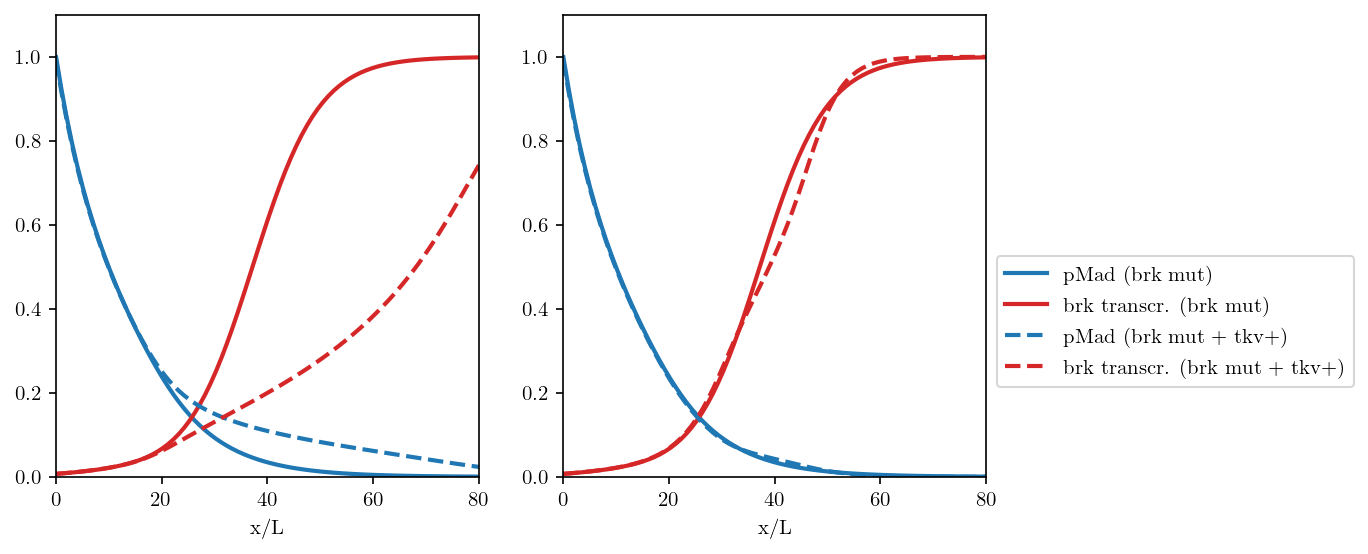

In [25]:
plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

vx, vpmad_mut, vbrk_trans_mut, vpmad_nobrktkv, vbrk_trans_nobrktkv = compare(
    c_dep_sol_mut, c_dep_sol_nobrktkv
)
ax[0].plot(
    vx, vpmad_mut, c="tab:blue", linestyle="-", label="pMad (brk mut)", linewidth=2
)
ax[0].plot(vx, vbrk_trans_mut, c="tab:red", label="brk transcr. (brk mut)", linewidth=2)
ax[0].plot(
    vx,
    vpmad_nobrktkv,
    c="tab:blue",
    linestyle="--",
    label="pMad (brk mut + dad RNAi)",
    linewidth=2,
)
ax[0].plot(
    vx,
    vbrk_trans_nobrktkv,
    c="tab:red",
    linestyle="--",
    label="brk transcr. (brk mut + dad RNAi)",
    linewidth=2,
)
ax[0].set(xlabel="x/L", xlim=(0, 80), ylim=(0, 1.1))

vx, vpmad_mut, vbrk_trans_mut, vpmad_nobrkdad, vbrk_trans_nobrkdad = compare(
    c_dep_sol_mut, c_dep_sol_nobrkdad
)
ax[1].plot(
    vx, vpmad_mut, c="tab:blue", linestyle="-", label="pMad (brk mut)", linewidth=2
)
ax[1].plot(vx, vbrk_trans_mut, c="tab:red", label="brk transcr. (brk mut)", linewidth=2)
ax[1].plot(
    vx,
    vpmad_nobrkdad,
    c="tab:blue",
    linestyle="--",
    label="pMad (brk mut + tkv+)",
    linewidth=2,
)
ax[1].plot(
    vx,
    vbrk_trans_nobrkdad,
    c="tab:red",
    linestyle="--",
    label="brk transcr. (brk mut + tkv+)",
    linewidth=2,
)
ax[1].set(xlabel="x/L", xlim=(0, 80), ylim=(0, 1.1))

ax[1].legend(bbox_to_anchor=(1, 0.5))
plt.savefig('media/combined_SM_plots.pdf') if save else None

## <a id='toc4_1_'></a>[(a) ubi-tkv: set stkv2t=0 after parameter fit](#toc0_)

In [26]:
def equations_GRN_ubitkv_leastsq(vars, dpp, k5, k6):
    pmad, brk, dad, tkv = vars
    eq1 = (
        spmadtglobal
        * dpp
        * tkv
        * (madtotglobal / k5)
        / (1 + (madtotglobal / k5) + (dad / k6))
        / pmad
        - 1
    )
    eq2 = sbrktglobal / (1 + (pmad / k7global) ** h1global) / brk - 1
    eq3 = (
        sdad1tglobal
        + sdad2tglobal
        * (pmad / k4global) ** h3global
        / (1 + (pmad / k4global) ** h3global)
    ) / (1 + (brk / k3global) ** h2global) / dad - 1
    eq4 = (stkv1tglobal) / tkv - 1
    return [eq1, eq2, eq3, eq4]


def c_dep_sol_ubitkv(c, k5, k6):
    sol = least_squares(
        lambda vars: equations_GRN_ubitkv_leastsq(vars, c, k5, k6),
        (1, 1, 1, 1),
        bounds=(0, np.inf),
    )
    pmad, brk, dad, tkv = sol.x
    return pmad, brk, dad, tkv

[Text(0.5, 0, 'x/L'), (0.0, 80.0), (0.0, 1.1)]

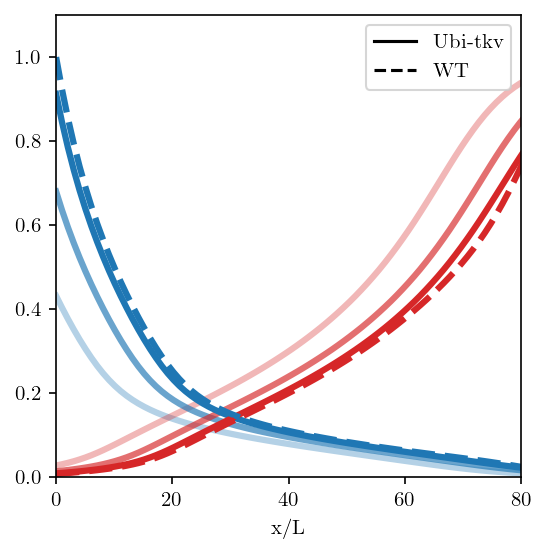

In [27]:
plt.close("all")
results_wt = GRN_spatial_integrator(lambda dpp: c_dep_sol_WT(dpp, k5=1, k6=1e-3))
vx, vdpp, vpmad = results_wt[0:3]
vbrk_trans = 1 / (1 + (vpmad / k7global) ** h1global)
J0_wt = (vdpp[1] - vdpp[0]) / (vx[1] - vx[0])

fig, ax = plt.subplots(figsize=(4, 4))
for redux in np.linspace(0.3, 0.9, 3):
    alpha = redux / 0.9
    J0 = J0_wt * redux
    results_ubitkv = GRN_spatial_integrator(
        lambda dpp: c_dep_sol_ubitkv(dpp, k5=1, k6=1e-3), lbc_type="neumann", lbc_val=J0
    )
    vx, vpmad_ubitkv = results_ubitkv[0], results_ubitkv[2]
    vbrk_trans_ubitkv = 1 / (1 + (vpmad_ubitkv / k7global) ** h1global)
    ax.plot(vx, vpmad_ubitkv, linestyle="-", c="tab:blue", linewidth=3, alpha=alpha)
    ax.plot(vx, vbrk_trans_ubitkv, linestyle="-", c="tab:red", linewidth=3, alpha=alpha)

ax.plot(vx, vpmad, linestyle="--", c="tab:blue", linewidth=3)
ax.plot(vx, vbrk_trans, linestyle="--", c="tab:red", linewidth=3)

ax.plot([], [], linestyle="-", c="k", label="Ubi-tkv")
ax.plot([], [], linestyle="--", c="k", label="WT")
ax.legend()
ax.set(xlabel="x/L", xlim=(0, 80), ylim=(0, 1.1))

## <a id='toc4_2_'></a>[(b) dad mutant: set sdad1t=sdad2t=0 after fit](#toc0_)

In [28]:
def equations_GRN_dadmut_leastsq(vars, dpp, k5, k6):
    pmad, brk, tkv = vars
    eq1 = (
        spmadtglobal
        * dpp
        * tkv
        * (madtotglobal / k5)
        / (1 + (madtotglobal / k5))
        / pmad
        - 1
    )
    eq2 = sbrktglobal / (1 + (pmad / k7global) ** h1global) / brk - 1
    eq3 = (
        stkv1tglobal
        + stkv2tglobal
        * (brk / k2global) ** h4global
        / (1 + (brk / k2global) ** h4global)
    ) / tkv - 1
    return [eq1, eq2, eq3]


def c_dep_sol_dadmut(c, k5, k6):
    sol = least_squares(
        lambda vars: equations_GRN_dadmut_leastsq(vars, c, k5, k6),
        (1, 1, 1),
        bounds=(0, np.inf),
    )
    pmad, brk, tkv = sol.x
    dad = 0
    return pmad, brk, dad, tkv

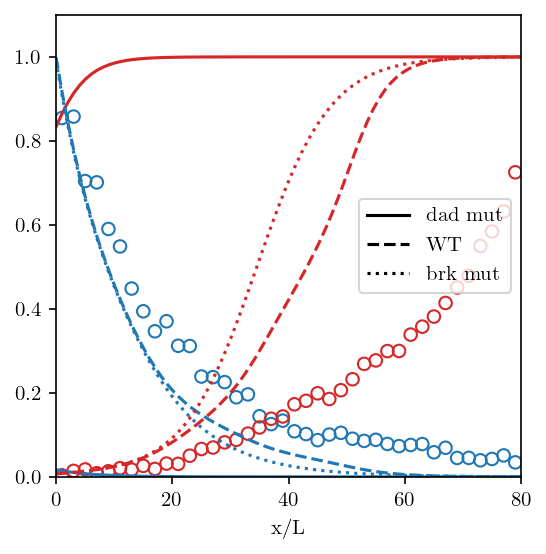

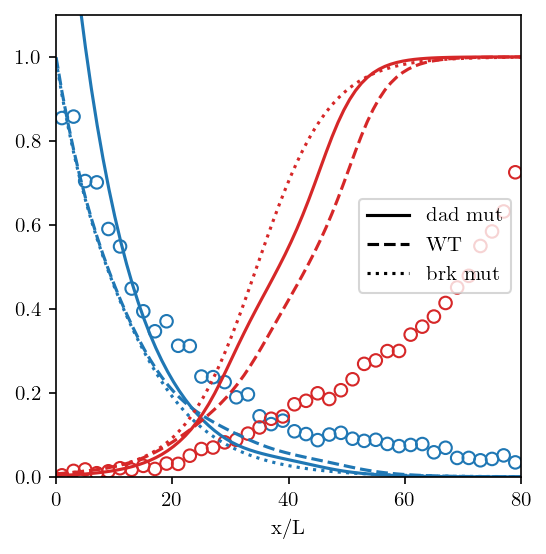

In [29]:
plt.close("all")


def plot_dadmut(J0):
    x2, p2, b2, pm2, bm2 = compare(c_dep_sol_WT, c_dep_sol_mut, 100, 0.1)
    x1, _, p1, b1 = GRN_spatial_integrator(
        lambda dpp: c_dep_sol_dadmut(dpp, k5=100, k6=0.1),
        lbc_type="neumann",
        lbc_val=J0,
    )[0:4]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(x1, p1, c="tab:blue", linestyle="-")
    ax.plot(x1, b1, c="tab:red", linestyle="-")
    ax.plot(x2, p2, c="tab:blue", linestyle="--")
    ax.plot(x2, b2, c="tab:red", linestyle="--")
    ax.plot(x2, pm2, c="tab:blue", linestyle=":")
    ax.plot(x2, bm2, c="tab:red", linestyle=":")
    ax.plot([], [], linestyle="-", c="k", label="dad mut")
    ax.plot([], [], linestyle="--", c="k", label="WT")
    ax.plot([], [], linestyle=":", c="k", label="brk mut")
    ax.scatter(
        100 * df_spatgrad["x/L"],
        df_spatgrad["Mean"],
        alpha=1,
        marker="o",
        edgecolor="tab:blue",
        facecolor="None",
    )
    ax.scatter(
        100 * df_spatgrad["x/L"],
        df_spatgrad["Mean.1"] / 0.9,
        alpha=1,
        marker="o",
        edgecolor="tab:red",
        facecolor="None",
    )
    ax.set(xlabel="x/L", xlim=(0, 80), ylim=(0, 1.1))
    ax.legend()


J0_dadmut_1, J0_dadmut_2 = -0.16 * 0.6, -27 * 0.6
plot_dadmut(J0_dadmut_1)
plot_dadmut(J0_dadmut_2)
plt.savefig('media/ubitkv_dadmut_phenotypes_clean_alternatives.pdf') if save else None

## <a id='toc4_3_'></a>[(c) brk replaced by strong tkv](#toc0_)

In [ ]:
def equations_GRN_tkvreplbrk_leastsq(vars, dpp, k5, k6, k2, h4, stkv2t):
    """remove repression of dad by brk but keep upregulation of tkv"""
    pmad, brk, dad, tkv = vars
    eq1 = (
        spmadtglobal
        * dpp
        * tkv
        * (madtotglobal / k5)
        / (1 + (madtotglobal / k5) + (dad / k6))
        / pmad
        - 1
    )
    eq2 = sbrktglobal / (1 + (pmad / k7global) ** h1global) / brk - 1
    eq3 = (
        sdad1tglobal
        + sdad2tglobal
        * (pmad / k4global) ** h3global
        / (1 + (pmad / k4global) ** h3global)
    ) / dad - 1
    eq4 = (
        stkv1tglobal
        + 10
        * stkv2t
        * (brk / k2) ** h4
        / (1 + (brk / k2) ** h4)
    ) / tkv - 1
    return [eq1**2, eq2**2, eq3**2, eq4**2]


def c_dep_sol_tkvreplbrk(c, k5, k6, k2=k2global, h4=h4global, stkv2t=stkv2tglobal):
    sol = least_squares(
        lambda vars: equations_GRN_tkvreplbrk_leastsq(vars, c, k5, k6, k2, h4, stkv2t),
        (0.5, 0.5, 1, 1),
        bounds=(0, np.inf),
    )
    pmad, brk, dad, tkv = sol.x
    return pmad, brk, dad, tkv

In [31]:
plt.close("all")
x1, _, p1, b1 = GRN_spatial_integrator(lambda dpp: c_dep_sol_tkvreplbrk(dpp, 1, 1e-3))[:4]
x2, rp2, rb2, p2, b2 = compare(c_dep_sol_WT, c_dep_sol_mut, 1, 1e-3)
output_array = np.vstack([x1, p1, b1, p2, b2]).T
np.savetxt('./brk_feedback_data/spatial_gradients_brk_plus_tkv.txt',output_array) if save else None

## <a id='toc4_4_'></a>[(d) brk replaced by dadRNAi (strong repression)](#toc0_)

In [32]:
k3_dadrnai = k3global
h2_dadrnai = h2global
def equations_GRN_dadRNAireplbrk_leastsq(vars,dpp,k5,k6,k3,h2, sdadt):
    """Remove upregulation of tkv by brk but keep repression of dad."""
    pmad,brk,dad,tkv = vars
    eq1 = spmadtglobal*dpp*tkv * (madtotglobal/k5)/(1 + (madtotglobal/k5) +(dad/k6))/pmad - 1
    eq2 = sbrktglobal / (1 + (pmad/k7global)**h1global)/brk - 1
    eq3 = (sdadt + sdadt * (pmad/k4global)**h3global/(1 + (pmad/k4global)**h3global))/ (1 + (brk/(k3))**h2)/dad - 1
    eq4 = stkv1tglobal/tkv - 1
    return [eq1,eq2,eq3,eq4]

def c_dep_sol_dadRNAireplbrk(c,k5,k6,k3=k3_dadrnai, h2=h2_dadrnai, sdadt=sdad1tglobal):
    sol = least_squares(lambda vars: equations_GRN_dadRNAireplbrk_leastsq(vars,c,k5,k6,k3,h2, sdadt), (1, 1, 1, 1),bounds=(0,np.inf))
    pmad,brk,dad,tkv =  sol.x
    return pmad,brk,dad,tkv

In [33]:
x1, _, p1 = GRN_spatial_integrator(lambda dpp: c_dep_sol_dadRNAireplbrk(dpp, 1, 1e-3))[:3]
b1 = 1 / (1 + (p1 / k7global) ** h1global)
x2, rp2, rb2, p2, b2 = compare(c_dep_sol_WT, c_dep_sol_mut, 1, 1e-3)
output_array = np.vstack([x1, p1, b1, p2, b2]).T
np.savetxt('./brk_feedback_data/spatial_gradients_brk_dadRNAi.txt',output_array) if save else None

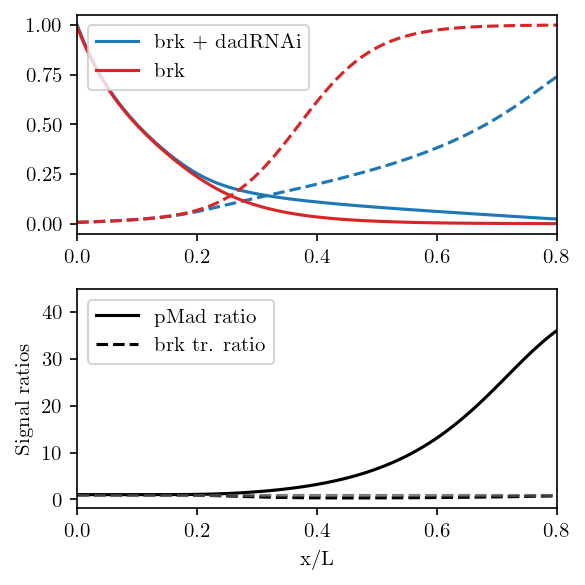

In [34]:
plt.close("all")
def plot_ratio(drx1, drx2, drp1, drb1, drp2, drb2, type="dadRNAi"):
    # normalise x 
    drx1 /= drx1[-1]
    drx2 /= drx2[-1]
    cutoff = 0.8
    fig, ax = plt.subplots(2, 1, figsize=(4, 4))
    ax[0].plot(drx1, drp1, "tab:blue")
    ax[0].plot(drx2, drb1, "tab:blue", linestyle="--")
    ax[0].plot(drx2, drp2, "tab:red")
    ax[0].plot(drx2, drb2, "tab:red", linestyle="--")
    ax[0].plot([], [], c="tab:blue", label=f"brk + {type}")
    ax[0].plot([], [], c="tab:red", label="brk")
    ax[0].set(xlim=(0, cutoff))
    ax[0].legend()


    ax[1].set(xlim=(0, cutoff))
    ax[1].hlines(1, 0, cutoff, linestyle="--", color="k", alpha=0.5)
    ax[1].set(xlabel="x/L", ylabel="Signal ratios")
    ax[1].plot(drx1, drp1 / drp2, linestyle="-", c="k", label="pMad ratio")
    ax[1].plot(drx1, drb1 / drb2, linestyle="--", c="k", label="brk tr. ratio")
    ax[1].legend()
    ax[1].hlines(1, 0, cutoff, linestyle="--", color="grey", alpha=0.5)
    ax[1].set(xlabel="x/L")
    plt.tight_layout()
    return fig, ax 
plot_ratio(x1,x2,p1,b1,p2,b2, "dadRNAi")
plt.savefig('media/drive_genotype_withratios.pdf') if save else None

## <a id='toc4_5_'></a>[(e) dadRNAi parameter sweep and fitting](#toc0_)

In [35]:
# EXTRACTING DATA
pmad_dadi = df_dadrnai[["pMad_dadi","pMad_dadi_std"]].to_numpy().T
scale = np.nanmax(pmad_dadi[0])
pmad_dadi = pmad_dadi /scale
brk_dadi = df_dadrnai[["brk_dadi","brk_dadi_std"]].to_numpy().T/scale
pmad_tkv = df_dadrnai[["pMad_tkv","pMad_tkv_std"]].to_numpy().T/scale
brk_tkv = df_dadrnai[["brk_tkv","brk_tkv_std"]].to_numpy().T/scale
pmad_KO = df_dadrnai[["pMad_KO","pMad_KO_std"]].to_numpy().T/scale
brk_KO = df_dadrnai[["brk_KO","brk_KO_std"]].to_numpy().T/scale

brk_norm = max(np.mean(brk_dadi[0,-10:]), np.mean(brk_tkv[0,-10:]), np.mean(brk_KO[0,-10:]))
brk_dadi_norm = brk_dadi/brk_norm
brk_tkv_norm = brk_tkv/brk_norm
brk_KO_norm = brk_KO/brk_norm


In [36]:
# fitting k3 and h2 
def loss_dadrnai(p):
    k3, h2 = p
    x1, _, p1 = GRN_spatial_integrator(
        lambda dpp: c_dep_sol_dadRNAireplbrk(dpp, 1, 1e-3, k3, h2)
    )[:3]
    p1[:84:2]
    b1 = 1 / (1 + (p1 / k7global) ** h1global)
    residual = np.sum((pmad_dadi[0] - p1[:84:2])**2) + np.sum((brk_dadi_norm[0] - b1[:84:2])**2)
    print(p, residual)
    return residual

In [37]:
f = lambda _, k3, h2 : GRN_spatial_integrator(
        lambda dpp: c_dep_sol_dadRNAireplbrk(dpp, 1, 1e-3, k3, h2)
    )[2][:84:2]
L = 84
x = np.linspace(0, 1, 100)
results_dadi = curve_fit(f, x, pmad_dadi[0],p0=[2e-3, 2e-1], bounds=([0,0],[np.inf,np.inf]))
print(f"k3 = {results_dadi[0][0]} +/- {np.sqrt(np.diag(results_dadi[1])[0])}")
print(f"h2 = {results_dadi[0][1]} +/- {np.sqrt(np.diag(results_dadi[1])[1])}")
k3_fit = results_dadi[0][0]
h2_fit = results_dadi[0][1]

k3 = 0.016716001274098603 +/- 0.008075924147020925
h2 = 1.0204302080610035 +/- 0.18400510835931677


In [38]:
x1, _, p1 = GRN_spatial_integrator(lambda dpp: c_dep_sol_dadRNAireplbrk(dpp, 1, 1e-3, k3=k3_fit, h2=h2_fit))[:3]
b1 = 1 / (1 + (p1 / k7global) ** h1global)
x2, rp2, rb2, p2, b2 = compare(c_dep_sol_WT, c_dep_sol_mut, 1, 1e-3)
output_array = np.vstack([x1, p1, b1, p2, b2]).T
np.savetxt(f'brk_feedback_data/spatial_gradients_brk_dadRNAi_k3_{k3_fit:.2f}_h2_{h2_fit:.2f}.txt',output_array, delimiter=",") if save else None

k3_fit = 1.7e-02, h2_fit = 1.0e+00
(0.01719323, 1.03018451) 3.28513428814463
3.28513428814463


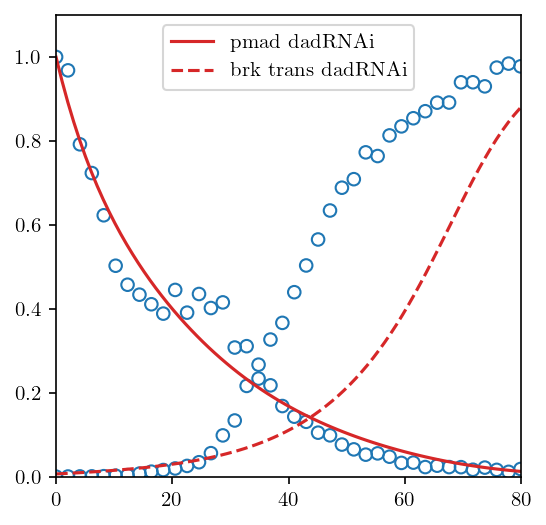

In [39]:
# PLOT AGAINST WT
k3_fit, h2_fit = 0.01719323, 1.03018451
print(f"{k3_fit = :.1e}, {h2_fit = :.1e}")
print(loss_dadrnai((k3_fit, h2_fit)))
x1, _, p1 = GRN_spatial_integrator(
    lambda dpp: c_dep_sol_dadRNAireplbrk(dpp, 1, 1e-3, k3_fit, h2_fit)
)[:3]
b1 = 1 / (1 + (p1 / k7global) ** h1global)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.set(xlim=(0, 80), ylim=(0, 1.1))
x = np.linspace(0, 84,42)
ax.scatter(x, pmad_dadi[0], alpha=1, marker="o", edgecolor="tab:blue", facecolor="None")
ax.scatter(x, brk_dadi_norm[0], alpha=1, marker="o", edgecolor="tab:blue", facecolor="None")
ax.plot(x1, p1, c="tab:red",  label="pmad dadRNAi")
# ax.plot(x1, vpmad, c="tab:blue", label="pmad WT")
ax.plot(x1, b1, linestyle="--", c="tab:red", label="brk trans dadRNAi")
# ax.plot(x1, vbrk_trans, linestyle="--", c="tab:blue", label="brk trans WT")
ax.legend()
plt.savefig('media/dadRNAi_fit.pdf') if save else None

k3_fit = 1.7e-02, h2_fit = 1.0e+00
(0.01719323, 1.03018451) 3.28513428814463
3.28513428814463


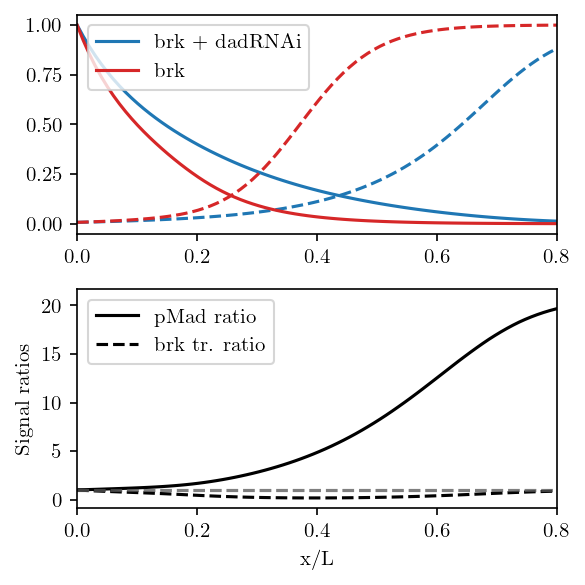

In [40]:
# PLOT AGAINST BM WITH RATIO
# k3_fit, h2_fit = 1e-3, 0.26 #best fit
k3_fit, h2_fit = 0.01719323, 1.03018451
L = 100.0
print(f"{k3_fit = :.1e}, {h2_fit = :.1e}")
print(loss_dadrnai((k3_fit, h2_fit)))
x1, _, p1 = GRN_spatial_integrator(
    lambda dpp: c_dep_sol_dadRNAireplbrk(dpp, 1, 1e-3, k3_fit, h2_fit)
)[:3]
b1 = 1 / (1 + (p1 / k7global) ** h1global)
plot_ratio(x1,x1,p1,b1,vpmad_mut,vbrk_trans_mut, "dadRNAi")
plt.savefig(f"media/dadRNAI_ratio_{k3_fit}_{h2_fit}.pdf") if save else None

In [41]:
def plot_ratio_errors(drx1, drx2, drp1, drb1, drp2, drb2, type="dadRNAi"):
    fig, ax = plt.subplots(2, 1, figsize=(4, 4))
    alpha = 0.1
    cutoff = 0.8
    ax[0].plot(drx1, drp1[0], c="tab:blue")
    ax[0].fill_between(drx1, drp1[0] - drp1[1], drp1[0] + drp1[1], color="tab:blue", alpha=alpha)
    ax[0].plot(drx2, drb1[0], c="tab:blue", linestyle="--")
    ax[0].fill_between(drx2, drb1[0] - drb1[1], drb1[0] + drb1[1], color="tab:blue", alpha=alpha)
    ax[0].plot(drx2, drp2[0], c="tab:red")
    ax[0].fill_between(drx2, drp2[0] - drp2[1], drp2[0] + drp2[1], color="tab:red", alpha=alpha)
    ax[0].plot(drx2, drb2[0], c="tab:red", linestyle="--")
    ax[0].fill_between(drx2, drb2[0] - drb2[1], drb2[0] + drb2[1], color="tab:red", alpha=alpha)

    ax[0].plot([], [], c="tab:blue", label=f"brk + {type}")
    ax[0].plot([], [], c="tab:red", label="brk")
    ax[0].set(xlim=(0, cutoff))
    ax[1].set(xlim=(0, cutoff))
    ax[1].hlines(1, 0, cutoff, linestyle="--", color="k", alpha=alpha)
    ax[1].set(xlabel="x/L", ylabel="Signal ratios")
    ratio_error_p = drp1[0] / drp2[0] * np.sqrt((drp1[1] / drp1[0]) ** 2 + (drp2[1] / drp2[0]) ** 2)
    ratio_error_b = drb1[0] / drb2[0] * np.sqrt((drb1[1] / drb1[0]) ** 2 + (drb2[1] / drb2[0]) ** 2)
    ax[1].plot(drx1, drp1[0] / drp2[0], linestyle="-", c="k", label="pMad ratio")
    ax[1].fill_between(drx1, drp1[0] / drp2[0] - ratio_error_p, drp1[0] / drp2[0] + ratio_error_p, color="k", alpha=alpha)
    ax[1].plot(drx1, drb1[0] / drb2[0], linestyle="--", c="k", label="brk tr. ratio")
    ax[1].fill_between(drx1, drb1[0] / drb2[0] - ratio_error_b, drb1[0] / drb2[0] + ratio_error_b, color="k", alpha=alpha)
    ax[1].legend()
    ax[1].hlines(1, 0, cutoff, linestyle="--", color="grey", alpha=alpha)
    ax[1].set(xlabel="x/L")
    plt.tight_layout()
    return fig, ax 


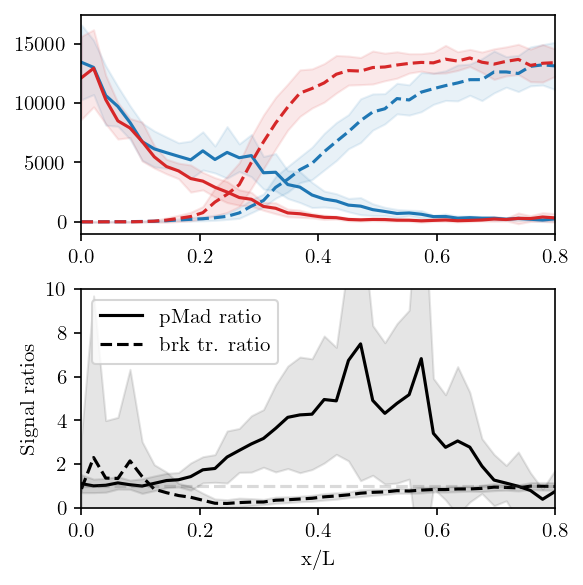

In [42]:
# PLOT OF DATA
M = np.linspace(0,pmad_KO.shape[1]/50,pmad_KO.shape[1])
# plot_ratio_errors(X,X,pmad_dadi, brk_dadi,pmad_KO,brk_KO)
plot_ratio_errors(M,M, pmad_dadi*scale, brk_dadi_norm*scale, pmad_KO*scale, brk_KO_norm*scale)
# plt.gca().set(yscale="log")
plt.gca().set(ylim=(0,10))
plt.savefig(f"media/dadRNAI_ratio_data.pdf") if save else None

In [43]:
def sweep(c_dep_sol, params, refval, name="param"):
    fig, ax = plt.subplots(1, 2)
    n_params = len(params)
    for i, param in enumerate(params):
        x1, _, p1 = GRN_spatial_integrator(
            lambda dpp: c_dep_sol(dpp, param)
        )[:3]
        b1 = 1 / (1 + (p1 / k7global) ** h1global)
        ax[0].plot(x1, p1, label=f"{name} = {param/refval:.2f} {name}*", alpha=(i + 1) / n_params, c="tab:blue")
        ax[1].plot(x1, b1, label=f"{name} = {param/refval:.2f} {name}*", alpha=(i + 1) / n_params, c="tab:blue")
    return fig, ax

## <a id='toc4_6_'></a>[(f) Tkv Overexpression Fitting](#toc0_)

In [44]:
# fitting k3 and h2 
def loss_tkv(p):
    k2, h4 = p
    x1, _, p1 = GRN_spatial_integrator(
        lambda dpp: c_dep_sol_tkvreplbrk(dpp, 1, 1e-3, k2=k2, h4=h4)
    )[:3]
    p1[:84:2]
    b1 = 1 / (1 + (p1 / k7global) ** h1global)
    residual = np.sqrt(np.sum((pmad_tkv[0] - p1[:84:2])**2) + np.sum((brk_tkv_norm[0] - b1[:84:2])**2))
    print(p, residual)
    return residual

In [45]:
# JUST FITTING PMAD
f_tkv = lambda x, k2, h4 : GRN_spatial_integrator(
        lambda dpp: c_dep_sol_tkvreplbrk(dpp, 1, 1e-3, k2, h4)
    )[2][:84:2]
def f_tkv(x, k2, h4):
    p1 = GRN_spatial_integrator(
        lambda dpp: c_dep_sol_tkvreplbrk(dpp, 1, 1e-3, k2, h4)
    )[2]
    loss = np.sum((p1[:84:2]-pmad_tkv[0])**2)
    print(k2, h4, loss)
    return p1[:84:2]
results_tkv = curve_fit(f_tkv, x, pmad_tkv[0], p0=[0.035,10], bounds=([0,0],[np.inf, np.inf]), diff_step=1)
print(f"k2 = {results_tkv[0][0]:.2e} +/- {np.sqrt(results_tkv[1][0,0]):.2e}")
print(f"h4 = {results_tkv[0][1]:.2e} +/- {np.sqrt(results_tkv[1][1,1]):.2e}")
k2_fit, h4_fit = results_tkv[0]


0.035 10.0 0.6108011596987097
0.07 10.0 0.9897685012057644
0.035 20.0 8.643052914162464
0.032837168138548985 10.200271557191886 2.5660400373881673
0.03329755857838827 10.049318739459668 0.6028501086119784
0.06659511715677655 10.049318739459668 0.8716569737971807
0.03329755857838827 20.098637478919336 8.870256629871765
0.031932795081782435 10.149341986223936 2.0785422973566683
0.03203085048371617 10.073414351245104 0.6027221416057805
0.06406170096743234 10.073414351245104 1.2968839007154325
0.03203085048371617 20.146828702490208 8.576575638785181
0.034987697530323894 10.067886582733161 2.858478316164354
0.03359804786739955 10.073423860937114 0.6030137882441797
0.03242264805975902 10.073417004358573 1.8819075232620297
0.03212879982153572 10.073415022770211 3.6262537702293183
0.03205533781508218 10.073414519576325 0.6019326936611198
0.06411067563016436 10.073414519576325 0.8361079373365542
0.03205533781508218 20.14682903915265 15.37167080227914
0.03209216963140066 10.073446800348279 0.601

In [46]:
plt.close("all")
k2_tkv, h4_tkv = 0.0329, 10
x1, _, p1, b1 = GRN_spatial_integrator(lambda dpp: c_dep_sol_tkvreplbrk(dpp, 1, 1e-3, k2=k2_tkv, h4=h4_tkv))[:4]
x2, rp2, rb2, p2, b2 = compare(c_dep_sol_WT, c_dep_sol_mut, 1, 1e-3)
output_array = np.vstack([x1, p1, b1, p2, b2]).T
np.savetxt(f'./brk_feedback_data/spatial_gradients_brk_plus_tkv_k2_{k2_tkv:.2f}_h4_{h4_tkv:.2f}.txt',output_array, delimiter=",") if save else None

In [47]:
c_dep_sol_tkvreplbrk(dpp, 1, 1e-3, k2=k2_tkv, h4=h4_tkv)

(0.6378318701104286,
 0.014642169046834979,
 0.15540560188970684,
 1.0047100104651152)

0.6015713109016351


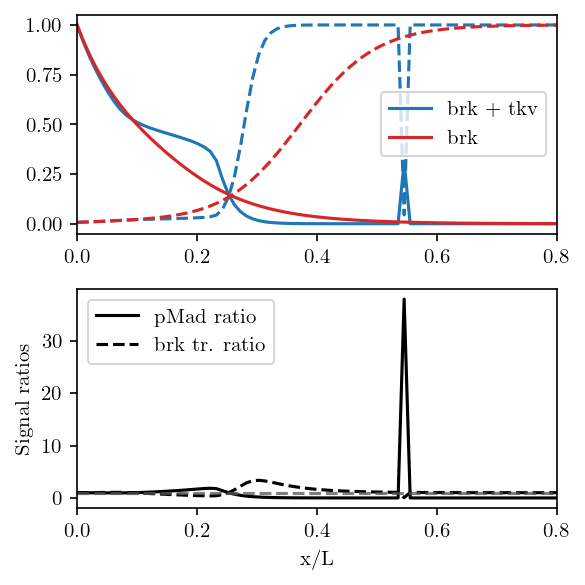

In [69]:
# PLOT AGAINST BM WITH RATIO
x1, _, p1 = GRN_spatial_integrator(
    lambda dpp: c_dep_sol_tkvreplbrk(dpp, 1, 1e-3, k2=k2_fit, h4=h4_fit)
)[:3]
p1[:84:2]
print(np.sum((p1[:84:2] - pmad_tkv[0])**2))
b1 = 1 / (1 + (p1 / k7global) ** h1global)
fig, ax = plot_ratio(x1,x1,p1,b1,vpmad_mut,vbrk_trans_mut, "tkv")
# ax[0].scatter(x1[:84:2], brk_KO)
plt.savefig(f"media/tkv_ratio_plot_{k2_fit:.2f}_{h4_fit:.2f}.pdf") if save else None

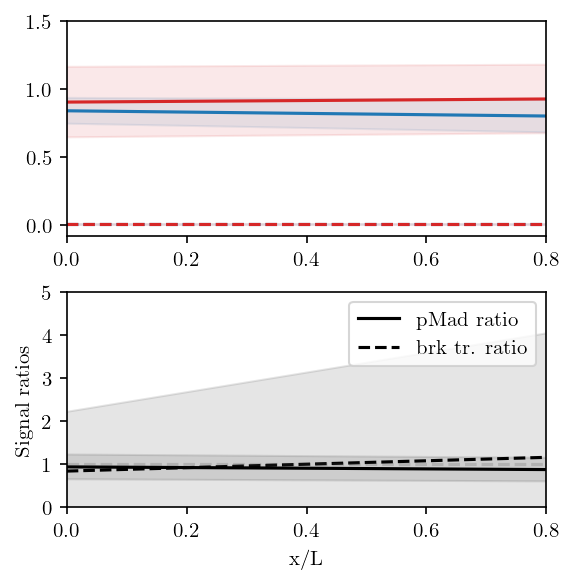

In [ ]:
# PLOT OF DATA
M = np.linspace(0,pmad_KO.shape[1]*100/50,pmad_KO.shape[1])
plot_ratio_errors(M,M, pmad_tkv, brk_tkv, pmad_KO,brk_KO, "tkv")
# plt.gca().set(yscale="log")
plt.gca().set(ylim=(0,5))
plt.savefig(f"media/tkv_ratio_data.pdf")